In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab3.ipynb")

# Coding lab \#3

```{grid} 2 2 2 2 
**beam elements and frame problems**
:::{figure} figures/AshesiETHLogo.png
:align: right
:width: 300px
:::
```

:::{admonition} How to use this notebook?
This notebook is made of text cells and code cells. The code cells have to be **executed** to see the result of the program. \
To execute a cell, simply select it and click on the "play" button \(&#9658;\) in the tool bar just above the notebook, or type `shift+enter`
It is important to execute the code cells in their order of appearance in the notebook.

**As a first step**: execute the very first OtterGrader code cell at the very top of this notebook. 

If you are running into any problems, try restarting the kernel and then see if the issue persist. 
:::

## Learning goals

After using this notebook, you should be able to:
* compute frame problems in 2D
* understand Hermitian shape functions
* solve a linear system with the condensation method

## problem statement

The objective of this project is to write your own finite element code to simulate linear elastic frame structures under static loading in 2D.
Frame structures are found in structural engineering applications, such as for example bridges and roofing.
To this end, we will implement a finite element code for a network of beam elements, as detailed in the *lecture notes in Sections 12.4-12.5*.

%<img src="figures/beams_bridge.png" alt="bridge" style="width:400px;"/>
%<!-- <p style="font-style:italic;">Figure 1: steel bridge </p> -->


```{figure} figures/beams_bridge.png
:name: bridge
:alt: bridge
:class: bg-primary
:width: 600px
:align: center

```
<div style="text-align: center"> <sup><sub> image credit: https://www.seekpng.com/idown/u2w7r5o0a9o0a9o0\_stahlbrcke-steel-bridge-png/</sub></sup>  </div>

Recall that the implementation of bar and beam elements is fully analogous with the exception that beam elements carry three degrees of freedom per node in 2D (as opposed to two degrees of freedom per node for bars). Therefore, we can reuse a lot of the functionality and code already developed under project 2 (such as, e.g., the stiffness matrix assembly, setting of boundary conditions, and solving), while we do need to adjust a few parts of the code (such as, e.g., the element stiffness matrix, the size of matrices and vectors).

We will write our python script slightly differently than on truss structures, viz. by computing several parts in functions. 
You are provided with all the necessary code structure and, similar to the previous project setup, you are required to fill in the missing code or adjust parts of the code as indicated.
The main script below is set up fully analogously to the previous project.  

___
# problem 1 a)
:::{admonition} submission requirement
:class: tip
Consider a cantilever beam as shown below.

%<img src="figures/CantileverBeam.png" alt="cantilever beam" style="width:400px;"/>
%<!-- <p style="font-style:italic;">Figure 2: cantilever beam </p> -->

```{figure} figures/beam_rhs_P_x1x2.png
:name: cantilever beam
:alt: cantilever
:class: bg-primary
:width: 400px
:align: center

```

Assume that the beam has the following properties:
Young's modulus $E_y = 210$ GPa,
cross-sectional area $A = 10^{-2}\text{ m}^2$,
moment of inertia $I =4 \cdot 10^{-4}\text{ m}^4$ and
length $L = 0.8$ m.
A constant force $P = 150$ kN is applied at $x_1 = L$ in the positive $x_2$-direction, as shown.
Use only a *single element* to model the above cantilever beam problem with node 0 at $x_1 = 0$ and node 1 at $x_1 = L$. Let's work with Newtons [N], meters [m] and thus Pascals [Pa].



Follow the steps described in the coding section below. In the input section, fill out all necessary information to define problem 1. 
We will get to problems 2 and 3 at a later stage.
:::



***
# coding

### pre-processing

For this, we need to import some useful Python libraries.

**Execute the code cell below** so that the necessary libraries are imported.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from lib.plotting_functions import plot_initial_and_displaced_structure, plot_FEM_vs_analytical,plot_initial_structure_wo_nodes,show_plot_problem3
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
# Enable inline plotting in Jupyter Notebook
%matplotlib inline
# And display a message once all libraries are imported
print("Libraries imported.")

Libraries imported.


Fill out the problem specific input in the function below.

In [3]:
# Pre-processing step 1: problem-specific input
def input_definition(problem):
    ###########################################################################################################
    if problem == 1: 
        #----------------
        # problem 1:
        #----------------
        # fill out all the missing parts:
        L = 0.8
        # coordinates of the global nodes:
        nodal_positions = np.array([[0, 0],
                                    [L, 0]])
        
        # local-to-global map / node connectivity
        nodal_connectivities = np.array([[0, 1]])
        # material properties:
        Ey = 210E9
        A = 1E-2
        
        I =4E-4
        P = 150E3
        
        #Neumann_BCs = np.array([[node number, degree of freedom , non-zero force/moment applied ]]) 
        #                                      0/1/2 corr. to      as we will initialize 
        #                                      0: x1 - direction   the force vector with zeros  
        #                                      1: x2 - direction 
        #                                      2: theta - rotation 
                          
        Neumann_BCs = np.array([[1,1,P]])
        
        #Dirichlet_BCs = np.array([[node number, degree of freedom 0/1/2, prescribed displacement/rotation ]])
        #                                        0: x1 - direction 
        #                                        1: x2 - direction 
        #                                        2: theta - rotation 
        
        Dirichlet_BCs = np.array([[0,0,0],
                                 [0,1,0],
                                 [0,2,0]])
        
        print('problem 1 specific input is defined')

    ###########################################################################################################
    
    # ignore the remainder of this code block for now, we will get back to it when we answer problems 2 and 3.  
    
    ###########################################################################################################
    elif problem == 2:    
        #----------------
        # problem 2:
        #----------------
        L = 3
        nodal_positions = np.array([[0.0, 0.0], # coordinates of node 0
                                   [0,L],
                                   [0,2*L],
                                   [L,L],
                                   [L,2*L],
                                   [2*L,2*L],
                                   [3*L,2*L],
                                   [4*L,2*L],
                                   [2.5*L,2.5*L],
                                   [2.5*L,2*L]])

        nodal_connectivities = np.array([[0, 1],   # element 0: connects nodes 0 and 1;
                                [0,3],
                               [1,3],
                                [1,2],
                                [1,4],
                                [2,4],
                                [3,4],
                                [3,5],
                                [4,5],
                                [5,8],
                                [5,9],
                                [8,9],
                                [9,6],
                                 [6,7],
                                [6,8]])
        
        Ey = 210E9
        A = 1E-2
        I = 4E-4
        
        P = 800
        Neumann_BCs = np.array([[4,1,-5*P],
                       [5,1,-3*P],
                       [6,1,-2*P],
                       [7,1,-2*P]])
        
        Dirichlet_BCs = np.array([[0,0,0],
                                  [0,1,0],
                                  [0,2,0],
                                  [1,0,0],
                                  [1,1,0],
                                  [1,2,0],
                                  [2,0,0],
                                  [2,1,0],
                                  [2,2,0]])
        
    elif problem == 3:    
        #----------------
        # problem 3:
        #----------------     
        from lib.mystery import mystery_import
        nodal_connectivities, nodal_positions, Ey, A, I, Neumann_BCs, Dirichlet_BCs = mystery_import()
        print('problem 3 specific input is defined')
    ###########################################################################################################
    else:
        print('please enter 1,2 or 3!')
    return nodal_positions, nodal_connectivities, Ey, A, I, Neumann_BCs, Dirichlet_BCs   

### select input

Below you can select which problem we want to solve in this input section. 


:::{admonition} attention
:class: attention

Make sure to enter the problem number you are solving below. Ensure that **problem = 1 for your submission**!
:::



In [18]:
problem = 1
nodal_positions, nodal_connectivities, Ey, A, I, Neumann_BCs,Dirichlet_BCs  = input_definition(problem)

problem 1 specific input is defined


In [19]:
grader.check("input")

input results: All test cases passed!
input - 1 message: problem 1 - nice, you seem to have defined the input for problem 1 correctly.

___

### solving

The code snippet below computes the (by now hopefully well-known) variables.
In case you do not remember, the definition of each of these variables is given. 
However, something went wrong in the ```element_dof_connectivity array``` : make sure to **modifiy** the code shown below for this as required for **beams in 2D**! 

In [20]:
no_dofs_per_node = 3                               # number of dofs per node
no_global_nodes  = nodal_positions.shape[0]        # number of global nodes
no_global_dofs   = no_global_nodes * no_dofs_per_node  # number of global dofs
no_elements      = nodal_connectivities.shape[0]   # number of elements
no_Neumann_BCs   = Neumann_BCs.shape[0]            # number of external loads applied
no_Dirichlet_BCs = Dirichlet_BCs.shape[0]          # number of Dirichlet boundary conditions

# set up element_dof_connectivity:
nodes1 = nodal_connectivities[:, 0]
nodes2 = nodal_connectivities[:, 1]

element_dof_connectivity = np.column_stack([nodes1 * no_dofs_per_node, nodes1 * no_dofs_per_node + 1, nodes1 * no_dofs_per_node + 2,nodes2 * no_dofs_per_node, nodes2 * no_dofs_per_node + 1,nodes2 * no_dofs_per_node + 2]).astype(int)
print(element_dof_connectivity)

[[0 1 2 3 4 5]]


In [21]:
grader.check("initalizeVariables")

initalizeVariables results: All test cases passed!
initalizeVariables - 1 message: you have the correct amount of columns in element_dof_connectivity.

<!-- **To be modified for beams:** Here we introduce a function which computes the element stiffness matrix for a **bar** element, which we will later use, when we compute the global stiffness matrix.  
**Change** this function to work for **beam** elements in 2D. -->

We were hoping to get some help from an AI tool to write a function, which computes the element stiffness matrix for a beam element, which we could use later on, when we compute the global stiffness matrix.  

Unfortunately, something went wrong! **Modify** the code inside this function to work **correctly** for **beam** elements in 2D.

In [22]:
def compute_element_stiffness_matrix(A, Ey, I, nodal_positions, node1e, node2e):

        
        elm_orientation_vector = [nodal_positions[node2e, 1] - nodal_positions[node1e, 1],
                                  nodal_positions[node2e, 0] - nodal_positions[node1e, 0]]
        
        elm_orientation_angle = np.arctan2(elm_orientation_vector[0], elm_orientation_vector[1])
        elm_length = np.linalg.norm(elm_orientation_vector)


        axial_stiffness_matrix = (A*Ey / elm_length) * np.array([[1, 0, 0, -1, 0, 0],
                                                                        [0, 0, 0, 0, 0, 0],
                                                                        [0, 0, 0, 0, 0, 0],
                                                                        [-1, 0, 0 , 1, 0, 0],
                                                                        [0, 0, 0, 0, 0, 0],
                                                                        [0, 0, 0, 0, 0, 0]])
               
        
        local_beam_stiffness_matrix =  (2*Ey*I / elm_length**3) * np.array([[0, 0, 0, 0, 0, 0],
                                                                        [0, 6, 3*elm_length, 0, -6, 3*elm_length],
                                                                        [0, 3*elm_length, 2*elm_length**2, 0, -3*elm_length, elm_length**2],
                                                                        [0, 0, 0 , 0, 0, 0],
                                                                        [0, -6, -3*elm_length, 0, 6, -3*elm_length],
                                                                        [0, 3*elm_length, elm_length**2, 0, -3*elm_length, 2*elm_length**2]])   
    
        
        rotation_matrix = np.array([[np.cos(elm_orientation_angle), np.sin(elm_orientation_angle), 0, 0, 0, 0],
                                    [-np.sin(elm_orientation_angle), np.cos(elm_orientation_angle), 0, 0, 0, 0],
                                    [0, 0, 1, 0, 0, 0],
                                    [0, 0, 0, np.cos(elm_orientation_angle), np.sin(elm_orientation_angle), 0],
                                    [0, 0, 0, -np.sin(elm_orientation_angle), np.cos(elm_orientation_angle), 0],
                                    [0, 0, 0, 0, 0, 1]])

        # element stiffness matrix in global coordinate system
         
        local_element_stiffness_matrix = axial_stiffness_matrix + local_beam_stiffness_matrix
        element_stiffness_matrix = np.transpose(rotation_matrix) @ local_element_stiffness_matrix @ rotation_matrix

        return element_stiffness_matrix

In [23]:
grader.check("comuputeK")

comuputeK results: All test cases passed!
comuputeK - 1 message: your function to compute the element stiffness matrix works correctly.

We will write a general function to apply boundary conditions and solve a problem, which we will use later on. Most parts of this function are given, your task is to **fill out the missing information** to solve using the **condensation method**. Then execute the code cell so that we can use the function later on.

:::{admonition} Let us refresh our Python knowledge.
<!-- :class: dropdown -->

Recall from coding lab 2 that we can pull out particular rows and columns of a matrix as follows:    
  ```python   
       my_dofs = [5,9,12]  
       my_big_matrix[np.ix_(my_dofs, my_dofs)] # accessing small matrix within larger matrix 
                                                   
  ```


  We will be making use of the *scipy library* to treat sparse matrices and solve our linear system more efficiently (the mystery structure (problem 3) will run 3x faster (!) than previously).
  Particularly, we will make use of the ```csr_matrix``` and ```spsolve``` from the scipy linear algebra package, so we will import these two functionalities explicitly.
   ```python
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
  ```

You can take a look at the [**scipy documentation**](https://docs.scipy.org/doc/scipy/reference/index.html) , we will also guide you through this usage further down, when we solve our system. For the rest of the coding section, you already know all that you need from lab 2.

:::

In [24]:
def apply_BCs_and_solve(global_stiffness_matrix):
    
    # let's start by converting K to a sparse matrix using scipy (given):
    global_stiffness_matrix = csr_matrix(global_stiffness_matrix)

    # let's compute the DOFs associated with the Neumann and Dirichlet BCs
    # other than in lab 2, we do not do this in a loop, but directly fill up vectors.
    # The algorithm is identical, however, so this is given:
    non_zero_Neumann_BCs_dofs = (no_dofs_per_node * Neumann_BCs[:, 0].astype(int) 
                                 + Neumann_BCs[:, 1].astype(int))
    
    Dirichlet_BCs_dofs = (no_dofs_per_node * Dirichlet_BCs[:, 0].astype(int)
                          + Dirichlet_BCs[:, 1].astype(int))
    
    # for the condensation method we require the dofs associated with ALL Neumann DOFs, 
    # let's call those here (given):
    Neumann_BCs_dofs = list(set(range(no_global_dofs)) - set(Dirichlet_BCs_dofs))

    
    # Let's initialize the global force and displacement vectors:
    global_force_vector        = np.zeros(no_global_dofs) #6
    global_displacement_vector = np.zeros(no_global_dofs)

    # apply all Neumann and Dirichlet BCs to the global force and displacement vectors (given): 
    global_force_vector[non_zero_Neumann_BCs_dofs] = Neumann_BCs[:, 2]
    global_displacement_vector[Dirichlet_BCs_dofs] = Dirichlet_BCs[:, 2]

    # # TODO: extract submatrices KNN, KND and vectors UD, FN: 
    KNN = global_stiffness_matrix[np.ix_(Neumann_BCs_dofs,Neumann_BCs_dofs)] 
    KND = global_stiffness_matrix[np.ix_(Neumann_BCs_dofs,Dirichlet_BCs_dofs)] 
    
    UD = global_displacement_vector[np.ix_(Dirichlet_BCs_dofs)]
    FN = global_force_vector[np.ix_(Neumann_BCs_dofs)]

    rhs = FN-(KND@UD)  # pre-compute the right-hand-side (for efficiency)

    # # Solve the reduced system using sparse solver:
    # # given, making use of spsolve from scipy's linear algebra package
    UN = spsolve(KNN, rhs) 

    # # TODO: add entries of UN into the correct positions of the global displacement vector:
    global_displacement_vector[np.ix_(Neumann_BCs_dofs)] = UN
    
    #global_displacement_vector[]
    
    # # TODO: solve for the reaction forces:
    global_force_vector = global_stiffness_matrix@global_displacement_vector

    
    return global_displacement_vector, global_force_vector
#apply_BCs_and_solve(compute_element_stiffness_matrix)

Let us finish up the pre-processing by plotting our initial structure! Simply execute the code cell below.

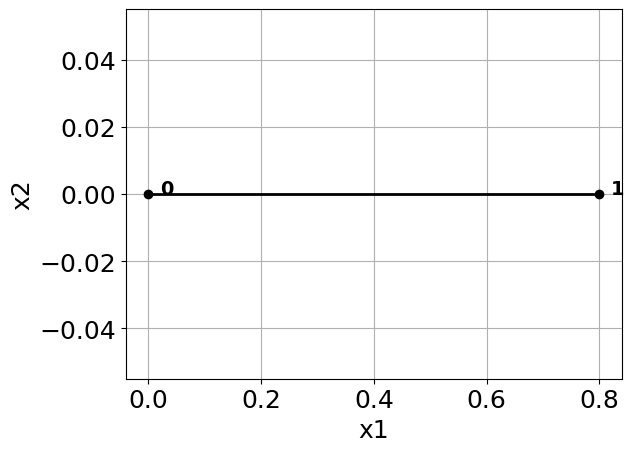

In [25]:
# let's plot the initial structure   
plot_initial_structure_wo_nodes(nodal_connectivities,nodal_positions,no_global_nodes,no_elements,problem)    

**Assembly of the global stiffness matrix and applying BCs and solving:** we loop over all elements and compute the elemental stiffness matrices making use of our function defined earlier on and assemble these to the correct positions into the global stiffness matrix. 

To enforce the essential and natural boundary conditions and computing the global displacement and force vectors, we simply make use of the function we defined earlier on.

Thererefore there are **no changes required** here. Simply execute this code block.

In [26]:
# ----------------------------------------------------------------------------------------------------------#
#                                                ASSEMBLE K
# ----------------------------------------------------------------------------------------------------------#
# initialize global stiffness matrix
global_stiffness_matrix = np.zeros((no_global_dofs, no_global_dofs))
# assemble global stiffness matrix

for e in range(no_elements):
    node1e = nodal_connectivities[e, 0]
    node2e = nodal_connectivities[e, 1]
    element_stiffness_matrix = compute_element_stiffness_matrix(A, Ey, I, nodal_positions, node1e, node2e)
    global_stiffness_matrix[np.ix_(element_dof_connectivity[e], element_dof_connectivity[e])] += element_stiffness_matrix
    
# ----------------------------------------------------------------------------------------------------------#
#                                               APPLYING BCs & SOLVING
# ----------------------------------------------------------------------------------------------------------#
# Apply Neumann and Dirichlet BCs, solve for displacement
global_displacement_vector, global_force_vector = apply_BCs_and_solve(global_stiffness_matrix)

# problem 1 b)

:::{admonition} submission requirement
:class: tip

Let us now analyze our results from our beam implementation. 
Let us use the shape functions derived in class to interpolate the deflection line along the beam, based on the computed nodal solutions.
Recall, that our deflection line in the FE context reads
$$
	w_e^h(x_1) = N^{1}_e(x_1)\, w_e^1 + N^{2}_e(x_1)\, w_e^2 + M^{1}_e(x_1)\, \theta_e^1 + M^{2}_e(x_1)\, \theta_e^2
$$
with the corresponding shape functions
$$
		N^{1}_e(x_1) = 1-3\left(\frac{x_1}{ L_e}\right)^2 + 2\left(\frac{x_1}{ L_e}\right)^3
		& \qquad
		N^{2}_e(x_1) = 3\left(\frac{x_1}{ L_e}\right)^2 - 2\left(\frac{x_1}{ L_e}\right)^3,\\
		M^{1}_e(x_1) = x\left(1-\frac{x_1}{ L_e}\right)^2,
		& \qquad
		M^{2}_e(x_1) = \frac{x_1^2}{ L_e}\left(\frac{x_1}{ L_e}-1\right).
$$
Of course, we remember the analytical solution for the beam deflection from our Mechanics of Solids classes, which is (measured positive in the negative $x_2$-direction): 
$$
	w(x_1) = \frac{P x_1^2}{6 E_y I } (3L - x_1).
$$
Let us verify our implementation by comparison with the analytical solution.

Plot the analytical and finite element solutions for the deflection $w(x_1)$ in one graph. Follow the prompts and use the space below to write your code. We will also print the forces, torques, displacements and rotations at the nodes to screen by following the prompts below. 
:::

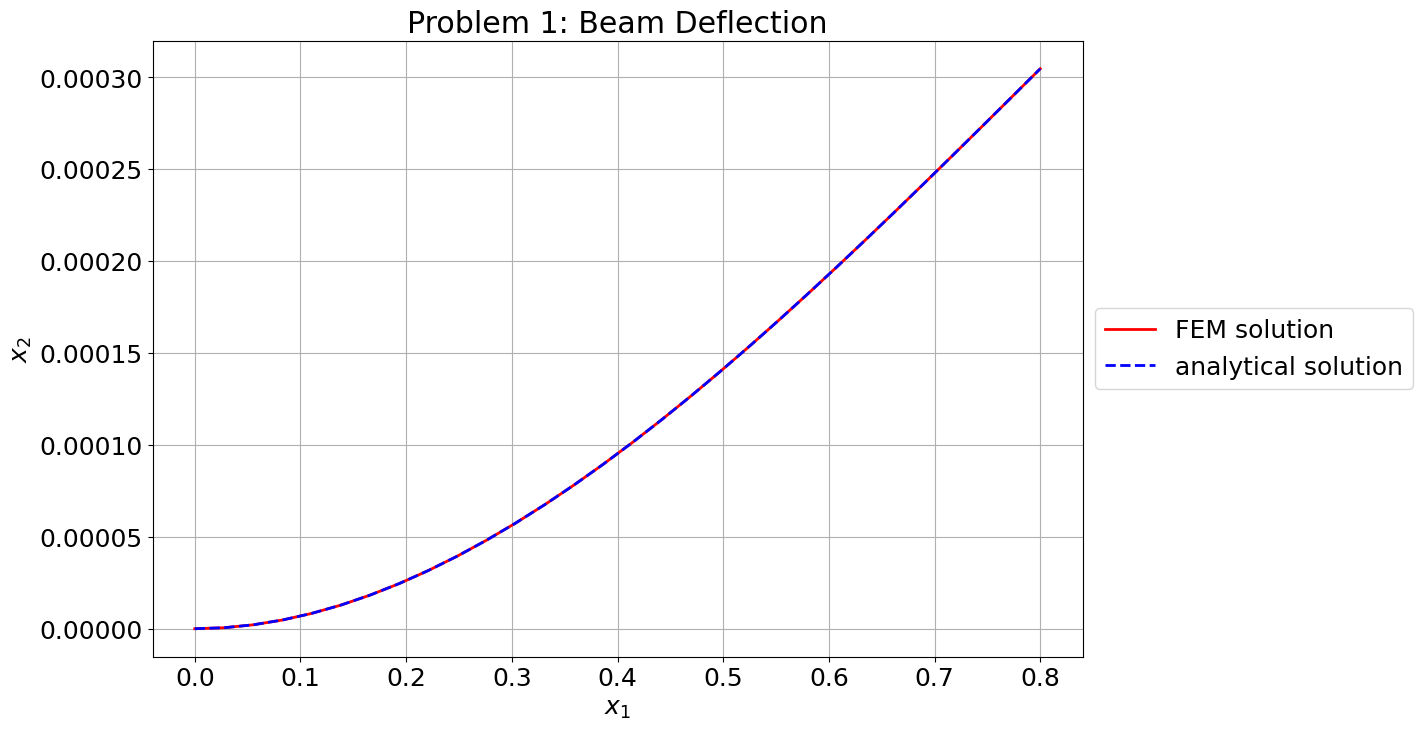

global_force_vector = 
 [ 0.00000000e+00 -1.50000000e+05 -1.20000000e+05  0.00000000e+00
  1.50000000e+05  2.91038305e-11]
global_displacement_vector = 
 [0.         0.         0.         0.         0.00030476 0.00057143]


In [27]:
# problem 1
if problem == 1:
    beam_length         = 0.8   # [m]
    length_probe_vector = 30  # length of vector where we probe the solution per element
    probe_vector        = np.linspace(0, beam_length, length_probe_vector) # vector of x1-positions where we compute w
    
    w_interp     = np.zeros(length_probe_vector) # vector of interpolated vertical deflections (FE solution)
    w_analytical = np.zeros(length_probe_vector) # vector of analytically computed vertical deflections along beam
    
    # compute the entries of w_interp and w_analytical here:
    
    # nodal displacements and rotations
    element_dof_connectivity
    w1 = global_displacement_vector[1]
    theta1 = global_displacement_vector[2]
    w2 = global_displacement_vector[no_dofs_per_node+1]
    theta2 = global_displacement_vector[no_dofs_per_node+2]
    L = beam_length
    
    # material properties:
    Ey = 210E9
    A = 1E-2
    I =4E-4
    
    P = 150E3
    
    
    for i, x in enumerate(probe_vector):
        xi = x / L
        N1 = 1 - 3*xi**2 + 2*xi**3
        N2 = 3*xi**2 - 2*xi**3
        M1 = x * (1 - xi)**2
        M2 = (x**2 / L) * (xi - 1)
    
        # FE interpolation
        w_interp[i] = N1*w1 + N2*w2 + M1*theta1 + M2*theta2
        w_analytical[i] = P * x**2 / (6 * Ey * I) * (3*L - x)
        
    # use the provided plotting function to plot the two solutions on one graph 
    plot_FEM_vs_analytical(probe_vector, w_interp,  w_analytical)
    
    # Report to screen
    print('global_force_vector = \n', global_force_vector)

    print('global_displacement_vector = \n',global_displacement_vector)

<!-- BEGIN QUESTION -->

:::{admonition} submission requirement
:class: tip

Do the two solutions match? Give a short explanation for why the results are or are not what you expected in the space provided below.
:::

The analytical and finite element (FEM) deflection plots match because the FEM uses the exact shape of the analytical beam solution for a simple bending case. In problem 1, the beam has only one element, and the Hermite cubic shape functions used in the FEM are derived directly from the exact Euler-Bernoulli beam theory (the same equations used for the analytical solution). Also, the nodal displacements and rotations in the FEM solution satisfy the same boundary conditions and equilibrium equations as the analytical model.

<!-- END QUESTION -->

___

# problem 2 a)
:::{admonition} submission requirement
:class: tip
Now that we have validated our beam implementation we move on to model more exciting structures. Below on the left-hand side you see a photograph of a viewing platform in the north of Italy. Inspired by this we have designed our very own viewing platform as shown on the right-hand side and wish to model and analyze it with our 2D beam finite element code that we have just written. 
<!-- We now consider the 2D frame problem of the structure shown in the figure below, which we solve by the finite element method. -->
%<img src="figures/bridge1.png" alt="2D beam network" style="width:600px;"/>
%<!-- <p style="font-style:italic;">Figure 3: 2D beam network </p> -->

```{figure} figures/viewing_platform.png
:name: 2D beam network
:alt: 2DBeamNetwork
:class: bg-primary
:width: 700px
:align: center

```

Each member is modeled by a 2-node beam element.

Input all relevant data in the input section at the beginning of this notebook for the problem as detailed in the figure above. 
The left hand-side is fully clamped, which means that all degrees of freedom of the clamped nodes are fixed.

Some people are already enjoying the view from our platform. 
We model them as equivalent forces at the nodes with $P = 800$ N. 
The length $L = 3$m and all beams have the same material properties and cross-sections: Young's modulus $E_y = 210$ GPa, cross-sectional area $A = 10^{-2}\text{ m}^2$, and the moment of inertia $I =4 \cdot 10^{-4}\text{ m}^4$.



Fill in all the necessary information to define this problem in the **input section** of the notebook. 
Additionally, make sure to **select problem = 2** in the *select input* code cell.

After running the code with the input for problem 2, use the provided function below to plot the initial and displaced structures on the same graph. 
We here choose to plot only the nodal displacements because plotting the exact deflection interpolation in 2D for each beam is more involved. 
The given code also prints the maximum vertical displacement to screen.

*Be careful with the interpretation of your plots: we only plot displaced nodal positions and do not interpolate across the elements (therefore, deformed beams appear as straight lines even though they are in fact curved cubic polynomials). Therefore, bear in mind that what you see is not the exact solution.*



Execute the notebook with problem = 2 and take a look at the plot of the initial and displaced structures on the same graph and the maximum vertical displacement, which is printed to screen. Then follow the subsequent questions.
:::



maximum vertical displacement =  -1.359  [mm]
 


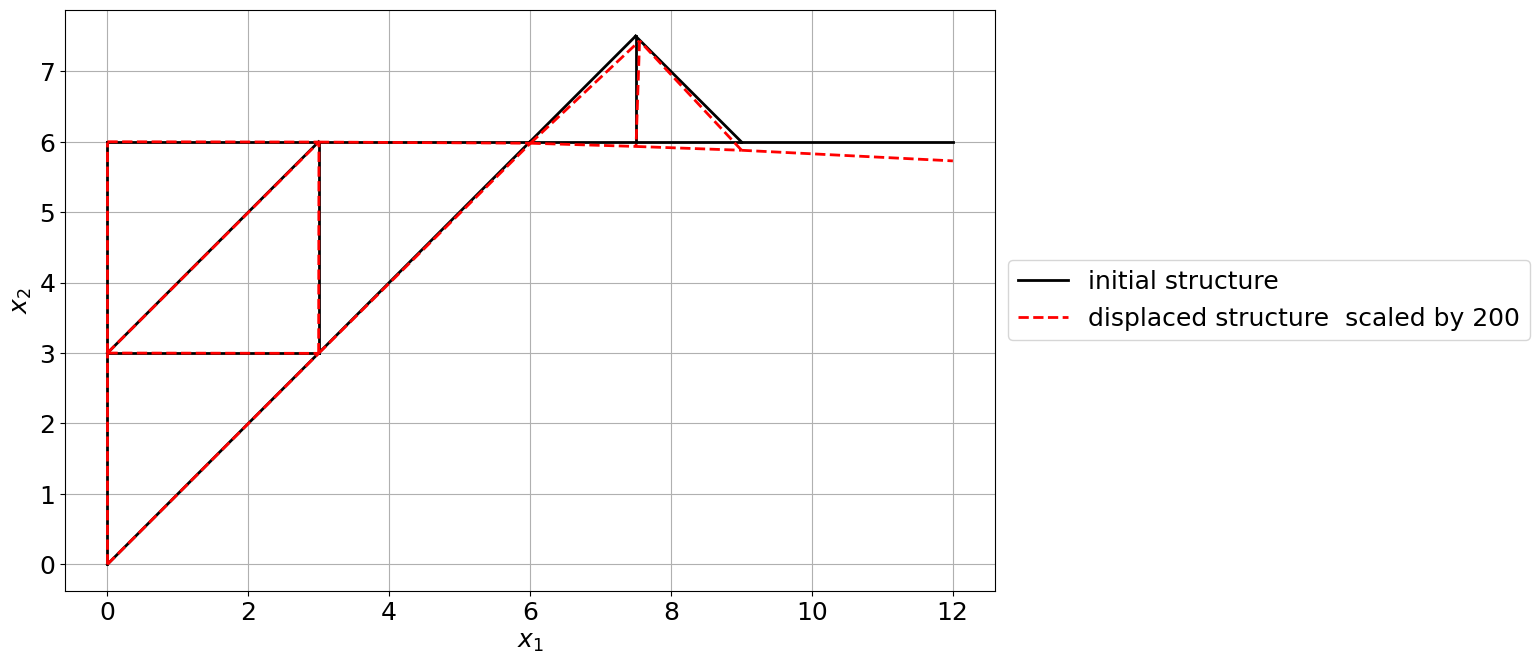

In [14]:
# problem 2
if problem == 2:

    scale_factor = 200
        
    # use plotting function to plot initial
    plot_initial_and_displaced_structure(nodal_connectivities, nodal_positions, global_displacement_vector, 
                                     no_elements, scale_factor,problem)

    print('maximum vertical displacement = ',f"{np.min(global_displacement_vector)*1000:.3f}", ' [mm]\n ') 


# problem 2 b)
:::{admonition} submission requirement
:class: tip

Copy the maximum vertical displacement displayed above (using millimeters!) into the field below. 
:::

In [15]:
max_vertical_displacement =-1.359 #[mm]

___
# problem 3 a)
:::{admonition} submission requirement
:class: tip

Let us test our code on a structure consisting of a large beam network (you can find out on your own what the mesh represents). 
At this point, your finite element code should be written generically so that you can simply run this notebook using the provided input file called mystery_beams with no changes needed.
Try it out! 

Simply **enter problem = 3 in the input section (code cell 4) and run the notebook**. Your code should simply be able to handle this input without any problems. All that is required is that your code runs with the provided input and we see the expected deformed plot below.

Then follow the instructions below to always display the displaced structure in this notebook.

*Note: thanks to our new solution method with sparse matrices and the condensation step this problem with just short of 10'000 DOFs should still execute in less than 30s (where most of time is taken up by the plotting function)!*
:::

In [16]:

if problem == 3:

    scale_factor = 200
    
    # Plot deformed structure
    plot_initial_and_displaced_structure(nodal_connectivities, nodal_positions,global_displacement_vector, 
                                     no_elements, scale_factor,problem)
    

<!-- BEGIN QUESTION -->

# problem 3 b)
:::{admonition} submission requirement
:class: tip
**Let's always show our plot for problem 3 here**: simply execute the code block below once you successfully ran problem = 3. 

*Do you recognize what this represents?* You're welcome to write your guess in the space provided below: no worries, this answer is not graded :-) 
:::

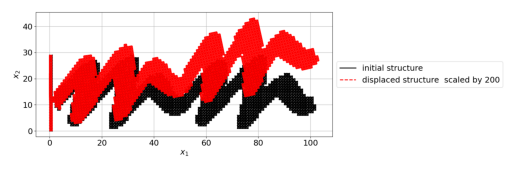

In [17]:
show_plot_problem3()

Mechanics & Materials Laboratory Logo

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

***

## Closing remarks

When you reach this part of the script, your code should be running just fine. 
In the inputs section we can simply choose the input corresponding to problems 1,2 and 3, respectively, and the code should execute without any problems. 
Further, you have taken some time to interpret some of the results. 


To close off this assignment on beam networks, write down three points of what you have learned during this project in the provided space below.

As a final point, you can also give an indication of how long it took you to complete this assignment. 

- I learnt about numerical computation of force and displacement for frame problems in 2D
- I learnt about hermitian shape functions and it use in comparing FEM and analytical result
- I learnt about how to solve linear system using the condensation method  

In [28]:
grader.check("Check saved problem 1 for submission")

Check saved problem 1 for submission results: All test cases passed!
Check saved problem 1 for submission - 1 message: great, you ran problem = 1 as required for submission.

<!-- END QUESTION -->

:::{admonition} important
:class: attention

**Run** and **save** your code with **problem = 1** in code cell 4 before submitting your **folder for coding lab 3** through Moodle! Please make sure that your notebook is called **lab3.ipynb** 

Best of luck!

:::